In [32]:
import kagglehub

import os
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

In [2]:
# Загрузка датасета
path = kagglehub.dataset_download("pawankumargunjan/imdb-review")
path = f"{path}\\aclImdb"

In [3]:
# Предобработка текста
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    words = [word for word in text.split() if word not in ENGLISH_STOP_WORDS]
    return ' '.join(words)

# Загрузка данных
def load_reviews(base_path):
    reviews = []
    labels = []
    for label in ['pos', 'neg']:
        folder_path = os.path.join(base_path, label)
        for filename in os.listdir(folder_path):
            with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as file:
                reviews.append(preprocess_text(file.read()))
                labels.append(1 if label == 'pos' else 0)
    return pd.DataFrame({'review': reviews, 'sentiment': labels})

In [33]:
def plot_confusion_matrix(y_true, y_pred, labels, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

In [4]:
# Функция для оценки модели
def evaluate_model(model, X_train, y_train, X_val, y_val):
    pipeline = make_pipeline(TfidfVectorizer(), model)
    pipeline.fit(X_train, y_train)
    
    # Предсказания
    y_pred = pipeline.predict(X_val)
    y_pred_proba = pipeline.predict_proba(X_val)[:, 1] if hasattr(pipeline[-1], "predict_proba") else None
    
    # Метрики
    print("\n" + "-"*30)
    print(f"Model: {model.__class__.__name__}")
    print("Accuracy:", accuracy_score(y_val, y_pred))
    print("F1-Score:", f1_score(y_val, y_pred))
    if y_pred_proba is not None:
        print("ROC AUC Score:", roc_auc_score(y_val, y_pred_proba))
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred, target_names=['Negative', 'Positive']))
    print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

In [5]:
data_train = load_reviews(f'{path}\\train')
data_test = load_reviews(f'{path}\\test')

# Разделение тренировочной выборки на обучающую и валидационную для экспериментов
X_train, X_val, y_train, y_val = train_test_split(
    data_train['review'], data_train['sentiment'], test_size=0.2, random_state=42
)

# Список моделей
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM (Linear Kernel)": SVC(kernel='linear', probability=True, random_state=42),
    "Naive Bayes": MultinomialNB()
}

In [6]:
# Оценка всех моделей
for model_name, model in models.items():
    evaluate_model(model, X_train, y_train, X_val, y_val)


------------------------------
Model: RandomForestClassifier
Accuracy: 0.846
F1-Score: 0.8452572347266881
ROC AUC Score: 0.9272084995059822

Classification Report:
              precision    recall  f1-score   support

    Negative       0.84      0.86      0.85      2485
    Positive       0.85      0.84      0.85      2515

    accuracy                           0.85      5000
   macro avg       0.85      0.85      0.85      5000
weighted avg       0.85      0.85      0.85      5000

Confusion Matrix:
 [[2127  358]
 [ 412 2103]]

------------------------------
Model: LogisticRegression
Accuracy: 0.8844
F1-Score: 0.8867998433215825
ROC AUC Score: 0.9547502110075963

Classification Report:
              precision    recall  f1-score   support

    Negative       0.90      0.87      0.88      2485
    Positive       0.87      0.90      0.89      2515

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88     

Лучшие результаты показали SVC (f-1 = 0.889), Логистическая регрессия (f-1 = 0.886), MultinomialNB (f-1 = 0.86), Случайный лес (f-1 = 0.845)

Логистическая регрессия быстро обучилась и показала хороший результат на уровне SVC, учитывающего контекст. Бдуем использовать ее

Кроме того, пусть регрессия в основном выявляет линейные зависимости, благодаря векторизации с помощью TF-IDF регрессия может "разделять классы" по сути на основе частоты встречаемости определенных слов в связке с оценкой

In [9]:
# Итоговая модель на тестовых данных
final_model = LogisticRegression(max_iter=1000, random_state=42)  # Логистическая регрессия
pipeline = make_pipeline(TfidfVectorizer(), final_model)
pipeline.fit(data_train['review'], data_train['sentiment'])

# Оценка на тестовой выборке
y_test_pred = pipeline.predict(data_test['review'])
y_test_proba = pipeline.predict_proba(data_test['review'])[:, 1]

print("\n" + "="*30)
print("Итоговая оценка модели на тестовых данных")
print("Точность (Accuracy):", accuracy_score(data_test['sentiment'], y_test_pred))
print("F1-Оценка (F1-Score):", f1_score(data_test['sentiment'], y_test_pred))
print("ROC AUC (Площадь под кривой):", roc_auc_score(data_test['sentiment'], y_test_proba))

print("\nОтчёт классификации:")
print(classification_report(data_test['sentiment'], y_test_pred, target_names=['Negative', 'Positive']))
print("Матрица ошибок (Confusion Matrix):\n", confusion_matrix(data_test['sentiment'], y_test_pred))


Итоговая оценка модели на тестовых данных
Точность (Accuracy): 0.87936
F1-Оценка (F1-Score): 0.8796104103464794
ROC AUC (Площадь под кривой): 0.9501038207999999

Отчёт классификации:
              precision    recall  f1-score   support

    Negative       0.88      0.88      0.88     12500
    Positive       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000

Матрица ошибок (Confusion Matrix):
 [[10966  1534]
 [ 1482 11018]]



Итоговая оценка модели на тестовых данных
Точность (Accuracy): 0.87936
F1-Оценка (F1-Score): 0.8796104103464794
ROC AUC (Площадь под кривой): 0.9501038207999999

Отчёт классификации:
              precision    recall  f1-score   support

    Negative       0.88      0.88      0.88     12500
    Positive       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



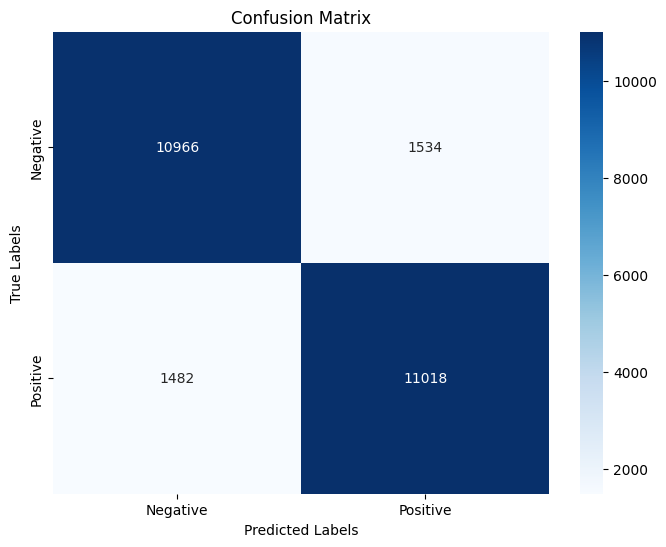

In [35]:
# Итоговая модель на тестовых данных с визуализацией матрицы ошибок
final_model = LogisticRegression(max_iter=1000, random_state=42)  # Логистическая регрессия
pipeline = make_pipeline(TfidfVectorizer(), final_model)
pipeline.fit(data_train['review'], data_train['sentiment'])

# Оценка на тестовой выборке
y_test_pred = pipeline.predict(data_test['review'])
y_test_proba = pipeline.predict_proba(data_test['review'])[:, 1]

print("\n" + "="*30)
print("Итоговая оценка модели на тестовых данных")
print("Точность (Accuracy):", accuracy_score(data_test['sentiment'], y_test_pred))
print("F1-Оценка (F1-Score):", f1_score(data_test['sentiment'], y_test_pred))
print("ROC AUC (Площадь под кривой):", roc_auc_score(data_test['sentiment'], y_test_proba))

print("\nОтчёт классификации:")
print(classification_report(data_test['sentiment'], y_test_pred, target_names=['Negative', 'Positive']))

# Построение матрицы ошибок
plot_confusion_matrix(data_test['sentiment'], y_test_pred, labels=['Negative', 'Positive'], 
                      title="Confusion Matrix")


Точность (Accuracy) составляет 87.9%. Это означает, что модель правильно классифицировала почти 88% отзывов из тестовой выборки.

F1-оценка равна 0.8796, что указывает на баланс между точностью и полнотой, подтверждая, что модель одинаково хорошо справляется с классификацией как положительных, так и отрицательных отзывов.

ROC AUC (площадь под кривой) равен 0.9501, что свидетельствует о высокой способности модели различать классы.

Отчет классификации показывает, что точность (precision) и полнота (recall) для обоих классов составляют 88%. Это говорит о том, что модель в равной степени хорошо справляется с определением как положительных, так и отрицательных отзывов.

10966 верных предсказаний для отрицательных отзывов и 1534 ошибочных (классифицированных как положительные - False Positive). 
11018 верных предсказаний для положительных отзывов и 1482 ошибочных (классифицированных как отрицательные - False Negative).

---

Посмотрим, что скажет модель на отзыв "Хороший фильм, но хуже, чем я ожидал"

In [30]:
predicted_class = pipeline.predict(['great movie but worse then i expected'])[0]
print(pipeline.predict_proba(['great movie but worse then i expected'])[0])
predicted_class


[0.67553198 0.32446802]


np.int64(0)

Модель посчитала отзыв негативным, но видно, что была еще и 30% вероятность того, что отзыв все же положительный

---

Посмотрим, что скажет модель на отзыв "Вообще не хороший фильм"

In [37]:
predicted_class = pipeline.predict(['quite not good movie'])[0]
print(pipeline.predict_proba(['quite not good movie'])[0])
predicted_class


[0.07900621 0.92099379]


np.int64(1)

Тут модель посчитала, что отзыв положительный ну просто железобетонно - вероятность этого модель оценила в ~92%

---